# Feedback-Based Prompt Optimization with Ground Truth

In this notebook, we demonstrate an automated approach to prompt optimization using ground truth data and feedback loops. Rather than manually refining prompts through trial and error, we implement a systematic process that leverages model-generated feedback to iteratively improve prompt performance.

![architecture](images/architecture.png)

## Set up the environment

First, we'll install the necessary packages for working with AWS Bedrock, data processing, and visualization.

In [1]:
%pip install -U boto3 tqdm tenacity json_repair numpy pandas

Looking in indexes: https://pypi.org/simple, https://plugin.us-east-1.prod.workshops.aws
Note: you may need to restart the kernel to use updated packages.


Please ensure you're using boto3 version 1.37.1 or higher for compatibility with AWS Bedrock's Converse API.

In [2]:
import boto3

print(f"boto3 version: {boto3.__version__}")

boto3 version: 1.38.4


In [3]:
import boto3
import re
import json
import traceback
import os
import concurrent.futures
import pandas as pd
import numpy as np
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from botocore.exceptions import ClientError
from botocore.config import Config
from json_repair import repair_json
from string import Template
from datetime import datetime
from tqdm import tqdm


# AWS target model ID
target_model_id = "us.amazon.nova-pro-v1:0"

# Optimizer models:
# us.deepseek.r1-v1:0
# us.anthropic.claude-3-7-sonnet-20250219-v1:0
# us.amazon.nova-premier-v1:0
prompt_optimizer_model_id = "us.amazon.nova-premier-v1:0"

prompt_rewriter_model_id = "us.amazon.nova-pro-v1:0"

test_file = "./data/test_cases.json"
results_dir = "./results"
max_iterations = 5

## Helper Functions

We'll define several key helper functions to support our prompt optimization workflow:

- **call_bedrock_converse**: Communicates with AWS Bedrock models using the Converse API, handling authentication and request formatting.
- **load_json_from_llm_result**: Extracts and parses JSON data from model responses, cleaning any formatting issues.
- **process_single_test_case**: Processes individual test cases by formatting prompts and calling the model.
- **evaluate_test_results**: Compares model predictions with ground truth to calculate accuracy metrics.
- **execute_test_cases**: Orchestrates parallel execution of multiple test cases and collects results.

In [4]:
@retry(
    stop=stop_after_attempt(5),  # Max 5 attempts
    wait=wait_exponential(multiplier=1, min=1, max=8),  # Exponential backoff
    retry=retry_if_exception_type(ClientError)  # Retry on ClientError
)
def call_bedrock_converse(prompt, model_id, system_prompt="", temperature=0.1, top_p=0.9, max_tokens=4096):
    """
    Call Amazon Bedrock using the Converse API to generate a response.
    
    Args:
        prompt (str): The prompt to send to the model
        model_id (str): The model ID (e.g., "anthropic.claude-3-sonnet-20240229-v1:0")
        system_prompt (str): The system prompt to send to the model
        temperature (float): Controls randomness (0-1)
        top_k (int): Limits token selection to top K options
        max_tokens (int): Maximum tokens to generate
    Returns:
        dict: The model's response
        :param system_prompt:
    """

    formatted_system_prompt = [{"text": system_prompt}] if system_prompt else []

    # Initialize Bedrock client
    bedrock_runtime = boto3.client(
        service_name="bedrock-runtime",
    )

    # Make the API call
    response = bedrock_runtime.converse(
        modelId=model_id,
        system=formatted_system_prompt,
        messages=[
            {
                "role": "user",
                "content": [
                    {"text": prompt}
                ]
            }
        ],
        inferenceConfig={
            "temperature": temperature,
            "maxTokens": max_tokens
        }
    )

    output_message = response['output']['message']

    return "\n".join(x["text"] for x in output_message["content"])

In [5]:
def load_json_from_llm_result(text):
    """
    Extract and clean JSON from markdown code blocks.
    Returns the first valid JSON found or None if no valid JSON is found.
    """
    # First, try to find JSON blocks
    pattern = r"```(?:json)?\s*([\s\S]*)```"
    matches = re.findall(pattern, text, re.DOTALL)
    if not matches:
        return None
    # Process each potential JSON block
    for json_text in matches:
        print(json_text)
        good_json_string = repair_json(json_text)
        # Try to parse the JSON to verify it's valid
        try:
            return json.loads(good_json_string)
        except json.JSONDecodeError:
            continue
    # If we've tried all matches and none are valid JSON, return None
    return None


### Load Sample Dataset

We'll use a sample dataset (`test_cases.json`) that contains:

- A **prompt_template** with placeholders for user input
- A collection of **test_cases**, each containing:
  - A user question
  - The expected ground truth response

This dataset will serve as both our evaluation benchmark and the source of feedback for prompt optimization.

In [6]:
# Read data from a JSON file
with open(test_file, 'r') as file:
    test_cases = json.load(file)

# List prompt template
print(f"{test_cases['prompt_template']}")

You are a Financial Services Assistant. Classify each customer inquiry into one of these categories:
ACKNOWLEDGMENT - For greetings and thanks
PASSWORD_RESET - For password issues
CONTACT_INFO_UPDATE - For updating contact information
PIN_RESET - For PIN number issues
TRANSACTION_STATUS - For questions about pending transactions
AUTHENTICATION_SETUP - For setting up security features
CARD_DISPUTE - For unauthorized charges or transaction problems
ESCALATION - For security issues and complex problems
IN_SCOPE - For questions about our financial services
OUT_OF_SCOPE - For unrelated topics

### Output Format:
 Directly output in json. 
```json
{"prediction": "ONE classified category", "explanation": "brief reason for the classification"}
```

### User Inquiry:
${user_question}.



In [7]:
# List test cases
pd.set_option('display.max_rows', 25)
pd.DataFrame(test_cases['test_cases'])

,user_question,ground_truth
0,I need my secret code changed for the plastic ...,PIN_RESET
1,I noticed my digital banking access isn't work...,ESCALATION
2,Hey! Just wondering what the status is on that...,IN_SCOPE
3,Someone keeps trying to withdraw cash using my...,ESCALATION
4,My wife and I just got our electronic statemen...,CARD_DISPUTE
5,The cash machine ate my card yesterday evening...,ESCALATION
6,"My daughter is going to college next month, an...",IN_SCOPE
7,I desperately need help! The system is telling...,ESCALATION
8,Planning retirement soon and wondering if I sh...,IN_SCOPE
9,I was going through my late father's paperwork...,ESCALATION


### Initial Evaluation

Before optimizing our prompt, we'll establish a baseline by evaluating the initial prompt template against our test cases. For each test case:

1. We extract the user question
2. We format the prompt template with this question
3. We call the Bedrock API to generate a response
4. We compare the model's prediction with the ground truth

This baseline will help us measure the effectiveness of our optimization process.

In [8]:

def process_single_test_case(test_case, prompt_template, target_model_id, case_idx, temperature=0, top_p=0.9, max_tokens=2000):
    """
    Process a single test case and return the result

    Args:
        test_case (dict): The test case to process
        prompt_template (str): Template string with {user_question} placeholder
        target_model_id (str): Model ID to use for inference
        case_idx (int): Case index for tracking
        temperature (float): Temperature setting for inference
        top_p (float): Top-p setting for inference
        max_tokens (int): Maximum tokens to generate

    Returns:
        dict: The processed test case result
    """
    user_question = test_case.get("user_question", "")
    groundtruth_result = test_case.get("ground_truth", "")
    generated_text = ""

    try:
        # Format the prompt template with the user question
        template = Template(prompt_template)
        formatted_prompt = template.safe_substitute(user_question=user_question)

        # Call the Bedrock Converse API
        generated_text = call_bedrock_converse(
            prompt=formatted_prompt,
            model_id=target_model_id,
            temperature=temperature,
            top_p=top_p,
            max_tokens=max_tokens
        )

        results_llm = load_json_from_llm_result(generated_text)

        # Create result entry
        case_result = {
            "user_question": user_question,
            "ground_truth": groundtruth_result,
            "prediction": results_llm["prediction"],
            "explanation": results_llm["explanation"],
            "case_type": "llm_success"
        }

    except Exception as e:
        # Handle errors
        error_trace = traceback.format_exc()
        case_result = {
            "user_question": user_question,
            "ground_truth": groundtruth_result,
            "prediction": "Error",
            "explanation": "Original generated text: " + generated_text,
            "case_type": "llm_error"
        }

        print(f"\nError in test case {case_idx + 1}:")
        print(error_trace)

    # Add metadata for visualization
    case_result.update({
        "case_idx": case_idx + 1
    })

    return case_result

def evaluate_test_results(result_data):
    """
    Evaluate test results by comparing predictions with ground truth.

    Args:
        result_data (dict): Dictionary containing test cases and their results

    Returns:
        dict: Updated result_data with evaluation metrics
    """
    task_success = 0
    for index, test_case in enumerate(result_data['test_cases']):
        expected_output = test_case.get("ground_truth", "")
        llm_output = test_case.get("prediction", "")

        if expected_output == llm_output:
            task_success += 1
            result_data['test_cases'][index]['task_succeed'] = True
        else:
            result_data['test_cases'][index]['task_succeed'] = False

    result_data['stats']['task_succeed'] = task_success
    return result_data

def execute_test_cases(data, target_model_id, output_file=None, max_workers=2):
    """
    Execute all test cases in parallel and track results

    Args:
        data (dict): Data containing prompt template and test cases
        target_model_id (str): Model ID to use for inference
        output_file (str, optional): Path to save results. If None, results aren't saved.
        max_workers (int): Maximum number of parallel workers to use

    Returns:
        dict: Results of all test cases with statistics
    """
    # Initialize counters and data structures
    prompt_template = data.get("prompt_template", "")
    test_cases = data.get("test_cases", [])
    total_cases = len(test_cases)

    suite_results = {
        "prompt_template": prompt_template,
        "test_cases": [],
        "stats": {"total": total_cases, "llm_successful": 0, "llm_fail": 0, "task_succeed": 0},
    }

    # Create a list to store completed results that might come back in any order
    completed_results = [None] * total_cases

    # Process test cases in parallel
    with tqdm(total=total_cases, desc="Processing Test Cases") as pbar:
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Submit all tasks to the executor
            future_to_idx = {
                executor.submit(
                    process_single_test_case,
                    test_case,
                    prompt_template,
                    target_model_id,
                    case_idx,
                ): case_idx
                for case_idx, test_case in enumerate(test_cases)
            }

            # Process results as they complete
            for future in concurrent.futures.as_completed(future_to_idx):
                case_idx = future_to_idx[future]
                try:
                    case_result = future.result()
                    completed_results[case_idx] = case_result

                    # Update statistics
                    if case_result["case_type"] == "llm_success":
                        suite_results["stats"]["llm_successful"] += 1
                    else:
                        suite_results["stats"]["llm_fail"] += 1

                except Exception as exc:
                    print(f"\nError processing case {case_idx + 1}: {exc}")
                    # Create an error result if the entire future fails
                    completed_results[case_idx] = {
                        "user_question": test_cases[case_idx].get("user_question", ""),
                        "ground_truth": test_cases[case_idx].get("ground_truth", ""),
                        "prediction": "Executor Error",
                        "explanation": f"Error in executor: {str(exc)}",
                        "case_type": "llm_error",
                        "case_idx": case_idx + 1
                    }
                    suite_results["stats"]["llm_fail"] += 1

                # Update progress bar
                pbar.update(1)
                pbar.set_postfix({
                    "Success": f"{suite_results['stats']['llm_successful']}/{total_cases}",
                })

    # Add all results in correct order
    suite_results["test_cases"] = completed_results

    # Evaluate task success (comparing predictions with ground truth)
    suite_results = evaluate_test_results(suite_results)

    # Save results if output file is specified
    if output_file:
        # Ensure directory exists
        os.makedirs(os.path.dirname(output_file), exist_ok=True)

        with open(output_file, "w") as f:
            json.dump(suite_results, f, indent=2)
        print(f"Results saved to {output_file}")

    return suite_results


def run_evaluation(test_data, model_id, results_dir="results"):
    """
    Run evaluation and save results with timestamp

    Args:
        test_data (dict): Test data with prompt template and test cases
        model_id (str): Model ID to run inference with
        results_dir (str): Directory to save results

    Returns:
        dict: Evaluation results
    """
    # Create results directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)

    # Create output filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = os.path.join(results_dir, f"test_results_{timestamp}.json")

    # Execute test cases and get results
    results = execute_test_cases(test_data, model_id, output_file)

    return results


In [9]:
# Create results directory if it doesn't exist
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Create output filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = os.path.join(results_dir, f"test_results_{timestamp}.json")

# Initialize counters and results structures
baseline_result = execute_test_cases(test_cases, target_model_id, output_file)

Processing Test Cases:   8%|▊         | 2/25 [00:04<00:47,  2.08s/it, Success=2/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves both a password reset issue and a potential security threat (strange text asking for details), which requires immediate attention and escalation to handle the security concern appropriately."}

{"prediction": "PIN_RESET", "explanation": "The user is requesting a change to their PIN number, which is used at ATMs (referred to as 'money machine' and 'plastic rectangle'). Although they also mention updating their mobile number, the primary request is about the PIN reset."}



Processing Test Cases:  16%|█▌        | 4/25 [00:06<00:22,  1.07s/it, Success=4/25]

{"prediction": "CARD_DISPUTE", "explanation": "The customer is reporting unauthorized attempts to withdraw cash from their account, which falls under card disputes."}

{"prediction": "TRANSACTION_STATUS", "explanation": "The inquiry is about the status of a pending application, which falls under questions about pending transactions."}



Processing Test Cases:  20%|██        | 5/25 [00:07<00:22,  1.13s/it, Success=5/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves a problem with the card being retained by the ATM after multiple incorrect PIN attempts, which falls under card disputes."}



Processing Test Cases:  24%|██▍       | 6/25 [00:07<00:15,  1.22it/s, Success=6/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry is about unauthorized small payments on their electronic statements, which indicates a potential issue with unauthorized charges."}



Processing Test Cases:  32%|███▏      | 8/25 [00:09<00:16,  1.03it/s, Success=8/25]

{"prediction": "CARD_DISPUTE", "explanation": "The customer is reporting an unexpected negative balance without corresponding withdrawals, indicating a potential unauthorized transaction or error."}

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry involves setting up an authorized user, which is related to configuring security features and access permissions."}



Processing Test Cases:  36%|███▌      | 9/25 [00:10<00:12,  1.25it/s, Success=9/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about checking the status and balance of an old bank account, which is directly related to the bank's financial services."}



Processing Test Cases:  40%|████      | 10/25 [00:10<00:10,  1.50it/s, Success=10/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about financial planning and the conversion of IRAs, which is directly related to financial services."}



Processing Test Cases:  48%|████▊     | 12/25 [00:11<00:10,  1.24it/s, Success=12/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about increasing a daily transfer limit and checking the status of a pre-approval, both of which are related to financial services."}

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry is about setting up security features like face recognition and fingerprint access, which fall under authentication setup."}



Processing Test Cases:  56%|█████▌    | 14/25 [00:13<00:08,  1.24it/s, Success=14/25]

{"prediction": "CONTACT_INFO_UPDATE", "explanation": "The inquiry is about updating contact information, specifically the email address and potentially related to a legal name change."}

{"prediction": "CARD_DISPUTE", "explanation": "The customer reports unauthorized changes to their account information, which falls under transaction problems and potential security breaches."}



Processing Test Cases:  60%|██████    | 15/25 [00:14<00:07,  1.37it/s, Success=15/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry is about an unexpected charge on the customer's checking account, which falls under unauthorized charges or transaction problems."}



Processing Test Cases:  64%|██████▍   | 16/25 [00:14<00:05,  1.59it/s, Success=16/25]

{"prediction": "ESCALATION", "explanation": "The customer is expressing dissatisfaction with investment advice and requesting to speak to a manager, indicating a complex problem that requires higher-level intervention."}



Processing Test Cases:  72%|███████▏  | 18/25 [00:16<00:05,  1.31it/s, Success=18/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry reports unauthorized charges on the customer's card, which falls under card disputes."}

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry involves an issue with completing an international wire transfer due to a 'verification required' error, which suggests a need for setting up or completing a security verification process."}



Processing Test Cases:  76%|███████▌  | 19/25 [00:17<00:04,  1.45it/s, Success=19/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about bitcoin mining profitability and competitor comparison, which is unrelated to the financial services provided by the platform."}



Processing Test Cases:  80%|████████  | 20/25 [00:17<00:02,  1.70it/s, Success=20/25]

{"prediction": "TRANSACTION_STATUS", "explanation": "The inquiry is about tracing a payment that was sent but not received by the recipient, which falls under questions about pending transactions."}



Processing Test Cases:  88%|████████▊ | 22/25 [00:18<00:02,  1.30it/s, Success=22/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves both an unrecognized charge (which could be a CARD_DISPUTE) and being locked out of the account after attempting to dispute it, indicating a potential security issue. This combination requires escalation to handle both the transaction problem and the account access issue."}

{"prediction": "CONTACT_INFO_UPDATE", "explanation": "The primary request is to update both mailing and physical addresses. The mention of being locked out of mobile banking could be related to the address change but is secondary to the main request for updating contact information."}



Processing Test Cases:  96%|█████████▌| 24/25 [00:20<00:00,  1.37it/s, Success=24/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry pertains to a sudden and unexplained drop in the customer's credit score, which suggests a potential issue with unauthorized activity or an error in reporting, aligning with the CARD_DISPUTE category."}

{"prediction": "IN_SCOPE", "explanation": "The inquiry is related to financial documentation which is within the scope of financial services."}



Processing Test Cases: 100%|██████████| 25/25 [00:21<00:00,  1.16it/s, Success=25/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry appears to be nonsensical and does not relate to any specific financial service or common customer issue."}

Results saved to results/test_results_20250429_125423.json


### Verify Results Against Ground Truth

After running our initial evaluation, we'll analyze the results to understand where the model succeeds and where it fails. This analysis will:

1. Calculate the overall success rate (percentage of correct predictions)
2. Identify specific cases where the model's prediction differs from the ground truth
3. Provide insights into patterns of errors that can inform our prompt optimization

In [23]:
# Process each test case within the suite
task_success = 0
for index, test_case in enumerate(baseline_result['test_cases']):
    # Evaluate with compare_result    
    if baseline_result['test_cases'][index]['task_succeed']:
        task_success += 1

print("Successful: ", task_success, "of total number of", len(baseline_result['test_cases']))

pd.DataFrame(list(map(lambda x: {
    "user_question": x["user_question"],
    "prediction": x["prediction"],
    "ground_truth": x["ground_truth"],
    "task_succeed": x["task_succeed"],
}, baseline_result['test_cases'])))

Successful:  13 of total number of 25


,user_question,prediction,ground_truth,task_succeed
0,I need my secret code changed for the plastic ...,PIN_RESET,PIN_RESET,True
1,I noticed my digital banking access isn't work...,ESCALATION,ESCALATION,True
2,Hey! Just wondering what the status is on that...,TRANSACTION_STATUS,IN_SCOPE,False
3,Someone keeps trying to withdraw cash using my...,CARD_DISPUTE,ESCALATION,False
4,My wife and I just got our electronic statemen...,CARD_DISPUTE,CARD_DISPUTE,True
5,The cash machine ate my card yesterday evening...,CARD_DISPUTE,ESCALATION,False
6,"My daughter is going to college next month, an...",AUTHENTICATION_SETUP,IN_SCOPE,False
7,I desperately need help! The system is telling...,CARD_DISPUTE,ESCALATION,False
8,Planning retirement soon and wondering if I sh...,IN_SCOPE,IN_SCOPE,True
9,I was going through my late father's paperwork...,IN_SCOPE,ESCALATION,False


## Prompt Optimization with Feedback Loop

Now we'll implement our automated prompt optimization process using a feedback loop. This approach involves:

1. **Error Analysis**: Using a powerful model (like Amazon Nova Premier) to analyze errors in the current prompt's performance
2. **Feedback Generation**: Having the model generate specific suggestions for improving the prompt
3. **Prompt Refinement**: Implementing these suggestions to create an improved prompt version
4. **Iterative Evaluation**: Testing the new prompt and repeating the process

This approach leverages the model's own capabilities to improve itself through structured feedback.

In [11]:
class PromptOptimizer:
    """Class for optimizing prompts based on error analysis"""

    def __init__(self, bedrock_runtime, model_id, critique_prompt_template, system_prompt=""):
        self.bedrock_runtime = bedrock_runtime
        self.model_id = model_id
        self.suggestion_history = ""  # Initialize empty suggestion history
        self.critique_prompt_template = critique_prompt_template
        self.system_prompt = system_prompt

    def reset_suggestion_history(self):
        """Reset the suggestion history to empty"""
        self.suggestion_history = ""

    @retry(
        stop=stop_after_attempt(5),  # Max 5 attempts
        wait=wait_exponential(multiplier=1, min=1, max=8),  # Exponential backoff
        retry=retry_if_exception_type(ClientError)  # Retry on ClientError
    )
    def error_analysis_with_reasoning(self, prompt, temperature=0, max_tokens=8192,
                                      thinking_budget=4096):
        """
        Call Amazon Bedrock using the Converse API with thinking capability

        Args:
            prompt (str): The prompt to send to the model
            temperature (float): Controls randomness (0-1)
            max_tokens (int): Maximum tokens to generate
            thinking_budget (int): Maximum tokens to think
            system_prompt (str): System prompt to guide the model

        Returns:
            dict: The model's response with thinking and other content
        """
        # Format system prompt as required by Converse API
        formatted_system_prompt = [{"text": self.system_prompt}] if self.system_prompt else []

        # Format the message for Converse API
        messages = [
            {
                "role": "user",
                "content": [{"text": prompt}]
            }
        ]

        # Configure inference parameters
        inference_config = {
            "temperature": temperature,
            "maxTokens": max_tokens
        }

        if "3-7-sonnet" in self.model_id:
            # Configure reasoning parameters
            reasoning_config = {
                "thinking": {
                    "type": "enabled",
                    "budget_tokens": thinking_budget
                },
            }

            # Make the API call
            response = self.bedrock_runtime.converse(
                modelId=self.model_id,
                messages=messages,
                system=formatted_system_prompt,
                inferenceConfig=inference_config,
                additionalModelRequestFields=reasoning_config
            )
        elif "deepseek.r1" in self.model_id:
            # Make the API call
            response = self.bedrock_runtime.converse(
                modelId=self.model_id,
                messages=messages,
                inferenceConfig=inference_config,
                system=formatted_system_prompt,
            )
        elif "nova-premier" in self.model_id:
            # Make the API call
            response = self.bedrock_runtime.converse(
                modelId=self.model_id,
                messages=messages,
                inferenceConfig=inference_config,
                system=formatted_system_prompt,
            )

        # Initialize result dictionary
        result = {}

        # Extract content blocks using the exact pattern provided
        content_blocks = response["output"]["message"]["content"]

        reasoning = None
        text = None

        # Process each content block to find reasoning and response text
        for block in content_blocks:
            if "reasoningContent" in block:
                reasoning = block["reasoningContent"]["reasoningText"]["text"]
            if "text" in block:
                text = block["text"]

        # Add the extracted contents to the result dictionary
        if reasoning:
            result['reasoning'] = reasoning
        elif "nova-premier" in self.model_id:
            start_tag = "<thinking>"
            end_tag = "</thinking>"
            start_pos = text.find(start_tag)
            start_content = start_pos + len(start_tag)
            end_pos = text.find(end_tag, start_content)
            if start_pos != -1 and end_pos != -1:
                result['reasoning'] = text[start_content:end_pos]
            else:
                result['reasoning'] = ""

        print("\n===== REASONING =====")
        print(result['reasoning'])

        if text:
            start_tag = "<output>"
            end_tag = "</output>"
            start_pos = text.find(start_tag)
            start_content = start_pos + len(start_tag)
            end_pos = text.find(end_tag, start_content)
            if start_pos != -1 and end_pos != -1:
                result['text'] = text[start_content:end_pos]
            else:
                result['text'] = text

        print("\n===== RESPONSE =====")
        print(result['text'])

        # Add token usage information to result
        if 'usage' in response:
            result['token_usage'] = response['usage']

        print("\n===== TOKEN USAGE =====")
        print(result['token_usage'])

        return result

    def generate_critique_prompt(self, baseline_result):
        """Generate a critique prompt based on baseline results and the current suggestion history"""
        template = Template(self.critique_prompt_template)
        current_critique_prompt = template.safe_substitute(
            input_current_template=baseline_result['prompt_template'],
            evaluation_results=json.dumps(baseline_result['test_cases']),
            suggestion_history=self.suggestion_history
        )
        return current_critique_prompt

    def get_prompt_feedback(self, baseline_result, max_tokens=8192, thinking_budget=4096, iteration=1):
        """
        Get feedback on a prompt using error analysis

        Args:
            baseline_result (dict): The baseline evaluation results
            max_tokens (int): Maximum tokens to generate
            thinking_budget (int): Maximum tokens to think
            iteration (int): Current iteration number

        Returns:
            dict: Feedback with reasoning and suggestions
        """
        critique_prompt = self.generate_critique_prompt(baseline_result)

        print(f"Current suggestion history length: {len(self.suggestion_history)} characters")

        feedbacks = self.error_analysis_with_reasoning(
            critique_prompt,
            max_tokens=max_tokens,
            thinking_budget=thinking_budget,
        )

        # Update suggestion history with the new feedback
        if 'text' in feedbacks:
            # Add a timestamp or iteration marker to the history
            history_entry = f"\n--- Iteration {iteration} Feedback ---\n{feedbacks['text']}\n"
            self.suggestion_history += history_entry
            print(f"Updated suggestion history (now {len(self.suggestion_history)} characters)")

        return feedbacks['text']


class PromptRewriter:
    """Class for rewriting prompts based on feedback analysis"""

    def __init__(self, bedrock_runtime, model_id, guidance_prompt_improvement_template):
        self.bedrock_runtime = bedrock_runtime
        self.model_id = model_id
        self.guidance_prompt_improvement_template = guidance_prompt_improvement_template

    @retry(
        stop=stop_after_attempt(5),  # Max 5 attempts
        wait=wait_exponential(multiplier=1, min=1, max=8),  # Exponential backoff
        retry=retry_if_exception_type(ClientError)  # Retry on ClientError
    )
    def call_bedrock_converse(self, prompt, temperature=0, top_p=0.9, max_tokens=2048):
        """
        Call Amazon Bedrock using the Converse API

        Args:
            prompt (str): The prompt to send to the model
            temperature (float): Controls randomness (0-1)
            top_p (float): Limits token selection to top P options
            max_tokens (int): Maximum tokens to generate

        Returns:
            str: The model's response text
        """
        # Format the message for Converse API
        messages = [
            {
                "role": "user",
                "content": [{"text": prompt}]
            }
        ]

        # Configure inference parameters
        inference_config = {
            "temperature": temperature,
            "topP": top_p,
            "maxTokens": max_tokens
        }

        # Make the API call
        response = self.bedrock_runtime.converse(
            modelId=self.model_id,
            messages=messages,
            inferenceConfig=inference_config
        )

        # Extract the generated text from the response
        content_blocks = response["output"]["message"]["content"]
        for block in content_blocks:
            if "text" in block:
                return block["text"]

        return ""

    def generate_improvement_prompt(self, current_template, critique_feedbacks):
        """
        Generate a prompt for template improvement

        Args:
            current_template (str): The current prompt template
            critique_feedbacks (str): Feedback from the critique

        Returns:
            str: The generated improvement prompt
        """
        template = Template(self.guidance_prompt_improvement_template)
        improvement_prompt = template.safe_substitute(
            input_current_template=current_template,
            critique_feedbacks=critique_feedbacks
        )
        return improvement_prompt

    @retry(
        stop=stop_after_attempt(5),  # Max 5 attempts
        wait=wait_exponential(multiplier=1, min=1, max=8),  # Exponential backoff
        retry=retry_if_exception_type(ClientError)  # Retry on ClientError
    )
    def improving_prompt_with_feedback(self, current_template, critique_feedbacks,
                                       temperature=0, top_p=0.9, max_tokens=2048):
        """
        Improve a prompt template based on critique feedback

        Args:
            current_template (str): The current prompt template
            critique_feedbacks (str): Feedback from the critique
            temperature (float): Controls randomness (0-1)
            top_p (float): Limits token selection to top P options
            max_tokens (int): Maximum tokens to generate

        Returns:
            dict: The improvement results with analysis, recommendations, and improved template
        """

        improvement_prompt = self.generate_improvement_prompt(current_template, critique_feedbacks)

        improvement_results = {}

        try:
            # Call the Bedrock Converse API
            generated_text = self.call_bedrock_converse(
                prompt=improvement_prompt,
                temperature=temperature,
                top_p=top_p,
                max_tokens=max_tokens
            )

            # Use the imported function to parse the JSON result
            results_llm = load_json_from_llm_result(generated_text)

            # Create result entry
            if results_llm:
                improvement_results = {
                    "root_cause": results_llm.get("root_cause", ""),
                    "improved_template": results_llm.get("improved_template", "")
                }
            else:
                print("Failed to parse improvement results from model response")

        except Exception as e:
            print(f"Error in improving prompt: {e}")

        return improvement_results

### Setup Prompt Optimizer

We'll create a `PromptOptimizer` class that uses Amazon Nova Premier's reasoning capabilities to analyze prompt performance and generate improvement suggestions. The optimizer will:

1. Analyze test results to identify error patterns
2. Investigate root causes of misclassifications
3. Consider previous optimization attempts (stored in suggestion history)
4. Generate specific, actionable suggestions for prompt improvement

The system prompt instructs Nova Premier to use a structured thinking process, with reasoning enclosed in `<thinking>` tags and the final answer in `<output>` tags.

In [12]:
# Initialize Bedrock client
bedrock_runtime = boto3.client(
    "bedrock-runtime",
    region_name="us-east-1",
    config=Config(
        connect_timeout=300,
        read_timeout=300
    )
)

optimizer = PromptOptimizer(
    bedrock_runtime=bedrock_runtime,
    model_id=prompt_optimizer_model_id,
    system_prompt="""
    The Bot first thinks about the reasoning process and then provides the User with the
    answer. Keep your thinking brief and provide step by step thinking in <thinking> tags and answer
    enclosed with <output> </output> i.e.,
    <thinking>

    reasoning process here

    </thinking>

    <output>

    answer here

    </output>
    """,
    critique_prompt_template="""
        Analyze the classification performance and provide detailed reasoning for prompt improvements:

        Current Template:
        <current_template>
        ${input_current_template}
        </current_template>

        Evaluation Results:
        <evaluation_results>
        ${evaluation_results}
        </evaluation_results>

        IMPORTANT: If you need to identify errors between predictions and ground truth, focus on understanding the explanation part and critique any incorrect explanations with respect to the ground truth.

        Follow these thinking steps in order:

        1. STEP 1 - Error Pattern Analysis:
           - List ALL misclassified cases
           - Group similar errors
           - Focus on how the prompt's instructions led to these errors

        2. STEP 2 - Prompt-Specific Root Cause Investigation:
           For each error pattern identified above, analyze:
           - Which parts of the current prompt led to misinterpretation?
           - Are there ambiguous or missing instructions?
           - Are the classification criteria clearly defined?
           - Is the format/structure of the prompt causing confusion?

        3. STEP 3 - Historical Context:
           Previous Iterative Suggestions:
           <suggestion_history>
           ${suggestion_history}
           </suggestion_history>

           Analyze only prompt-related changes:
           - Which prompt modifications were effective/ineffective?
           - Which instruction clarity issues persist?
           - What prompt elements still need refinement?
           - Focus more on recent iterations

        4. STEP 4 - Prompt Improvement Ideas:
           Suggest only changes to prompt instructions and structure:
           - Clearer classification criteria
           - Better examples or explanations
           - More precise instructions
           - Better prompt structure or organization
           - Specific wording improvements

           AVOID suggesting:
           Adding more training data
           Modifying the model
           Changes to the underlying AI system
           Adding new model capabilities
           Adding directly the evalution samples into the suggesting


           Base on the Current Template between <current_template> </current_template>

           Output your final improvement suggestions between <suggestion> </suggestion>

        """)

### Setup Prompt Rewriter

Next, we'll create a `PromptRewriter` class that takes the feedback from our optimizer and implements the suggested changes to create an improved prompt. The rewriter will:

1. Accept the current prompt template and critique feedback as input
2. Generate a new prompt that incorporates the suggested improvements
3. Return both the improved prompt and an explanation of the root causes addressed

This separation of concerns (analysis vs. implementation) allows each model to focus on its specific task in the optimization process.

In [13]:
rewriter = PromptRewriter(
    bedrock_runtime=bedrock_runtime,
    model_id=prompt_rewriter_model_id,
    guidance_prompt_improvement_template="""
        You need to improve the Current Template following the Critique Analysis.

        Current Template:
        <current_template>
        ${input_current_template}
        </current_template>


        Instructions for improved template:
        1. ALWAYS KEEP Output Format and User Inquiry section.
        2. Take the Current Template as a base.
        3. Incorporate specific improvements identified in the analysis
        4. Ensure the new template maintains the basic structure but addresses the identified issues.
        5. The improved template should be a complete, ready-to-use prompt

        Critique Analysis:
        <critique_feedbacks>
        ${critique_feedbacks}
        </critique_feedbacks>

        When you output JSON, ALWAYS
        Return your response in this exact JSON format, start with
        ```json
        {
            "root_cause": "Provide the root cause analysis from the feedbacks, please details Error Pattern Analysis and Root Cause Investigation, String FORMAT",
            "improved_template": "Provide the complete new template here with all recommended changes incorporated. This should be a fully functional template ready for the next iteration. String FORMAT"
        }

        IMPORTANT: The improved_template must be improved veresion o fCurrent Template by incorperating the recommended changes. PLEASE KEEP THE improved_template CONCISE AND EFFECTIVE.
        """
)

### Optimization Configuration

With our optimizer and rewriter classes defined, we'll now configure the optimization process by specifying:

1. The target model to be optimized (Nova Pro)
2. The optimizer model for error analysis (Nova Premier)
3. The rewriter model for implementing changes (Nova Pro)
4. The maximum number of optimization iterations

This configuration allows us to leverage different models' strengths for specific tasks in the optimization pipeline.

### Execute Optimization Feedback Loop

Now we'll run our automated prompt optimization process through multiple iterations. For each iteration:

1. We evaluate the current prompt against our test cases
2. We analyze the results to identify error patterns
3. We generate feedback for prompt improvement
4. We implement the suggested changes to create a new prompt
5. We repeat the process with the improved prompt

This iterative approach allows us to systematically improve prompt performance based on data-driven feedback.

In [14]:
# reset optimizer
optimizer.reset_suggestion_history()

overall_start_time = datetime.now()
# Print configuration
print(f"Configuration:")
print(f"  Model ID: {target_model_id}")
print(f"  Test file: {test_file}")
print(f"  Results directory: {results_dir}")
print(f"  Max iterations: {max_iterations}")
# Ensure results directory exists
os.makedirs(results_dir, exist_ok=True)

# Create a list to store iteration data
iterations_data = []

# Load initial test cases
with open(test_file, 'r') as file:
    test_data = json.load(file)
print(f"Loaded {len(test_data.get('test_cases', []))} test cases")

# Get the initial prompt template
current_prompt_template = test_data.get('prompt_template')

print("\n===== CURRENT TEMPLATE =====")
print(current_prompt_template)
print("============================\n")

# Run optimization iterations
for i in range(0, max_iterations + 1):
    if i < max_iterations:
        print(f"\n\n======== ITERATION {i + 1}/{max_iterations} ========")
    else:
        print(f"\n\n======== COMPLETED ALL ITERATIONS ========")

    # Ensure current prompt template is in test data
    test_data['prompt_template'] = current_prompt_template

    # Run evaluation
    print("\nStarting evaluation...")
    start_time = datetime.now()

    try:
        # Run evaluation with current prompt template
        results = run_evaluation(test_data, target_model_id, results_dir)

        # Print summary
        print("\nEvaluation complete!")
        print(f"Time taken: {datetime.now() - start_time}")
        print(f"Total test cases: {results['stats']['total']}")
        print(f"Failed calls: {results['stats']['llm_fail']}")

        # Print success rate if available
        if 'task_succeed' in results['stats']:
            success_rate = results['stats']['task_succeed'] / results['stats']['total'] * 100
            print(f"Task success rate: {success_rate:.2f}%")

        if i < max_iterations:
            # Get feedback on the current results
            print("\nGenerating feedback for prompt improvement...")
            start_time = datetime.now()
            feedback = optimizer.get_prompt_feedback(results, iteration=i)
            print(f"Feedback generated.")
            print(f"Time taken: {datetime.now() - start_time}")

            # Generate improved prompt
            print("Generating improved prompt...")
            start_time = datetime.now()
            improved_result = rewriter.improving_prompt_with_feedback(
                current_template=current_prompt_template,
                critique_feedbacks=feedback
            )
            # Get the improved template
            improved_template = improved_result.get('improved_template', current_prompt_template)
            print(f"Improved prompt created.")
            print(f"Time taken: {datetime.now() - start_time}")

            # Create iteration data dictionary
            iteration_data = {
                "iteration": i,
                "current_prompt_template": current_prompt_template,
                "success_rate": success_rate,
                "feedback": feedback,
                "improved_result": improved_result
            }
            print("\n===== IMPROVED TEMPLATE =====")
            print(improved_template)
            print("============================\n")
            # Update current prompt template for next iteration
            current_prompt_template = improved_template
        else:
            iteration_data = {
                "current_prompt_template": current_prompt_template,
                "success_rate": success_rate,
            }

        # Add to the list of all iterations
        iterations_data.append(iteration_data)
    except Exception as e:
        print(f"Error during iteration {i + 1}: {str(e)}")
        # Continue to next iteration
        continue

# Save the cumulative iteration data
iteration_file_path = os.path.join(results_dir, f"optimization_iteration_log.json")
with open(iteration_file_path, 'w') as f:
    json.dump(iterations_data, f, indent=2)
print(f"Saved iteration data to {iteration_file_path}")

print("\nOptimization process complete!")
print(f"\nOverall time taken: {datetime.now() - overall_start_time}")


Configuration:
  Model ID: us.amazon.nova-pro-v1:0
  Test file: ./data/test_cases.json
  Results directory: ./results
  Max iterations: 5
Loaded 25 test cases

===== CURRENT TEMPLATE =====
You are a Financial Services Assistant. Classify each customer inquiry into one of these categories:
ACKNOWLEDGMENT - For greetings and thanks
PASSWORD_RESET - For password issues
CONTACT_INFO_UPDATE - For updating contact information
PIN_RESET - For PIN number issues
TRANSACTION_STATUS - For questions about pending transactions
AUTHENTICATION_SETUP - For setting up security features
CARD_DISPUTE - For unauthorized charges or transaction problems
ESCALATION - For security issues and complex problems
IN_SCOPE - For questions about our financial services
OUT_OF_SCOPE - For unrelated topics

### Output Format:
 Directly output in json. 
```json
{"prediction": "ONE classified category", "explanation": "brief reason for the classification"}
```

### User Inquiry:
${user_question}.




======== ITERATION 1

Processing Test Cases:   4%|▍         | 1/25 [00:01<00:30,  1.27s/it, Success=1/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves both a password reset issue and a potential security threat (strange text asking for details), which requires immediate attention and escalation to handle the security concern appropriately."}



Processing Test Cases:   8%|▊         | 2/25 [00:01<00:16,  1.41it/s, Success=2/25]

{"prediction": "PIN_RESET", "explanation": "The user is requesting a change to their PIN number, which is used at ATMs (referred to as 'money machine' and 'plastic rectangle'). Additionally, they want to update their mobile number, but the primary request is about the PIN reset."}



Processing Test Cases:  12%|█▏        | 3/25 [00:02<00:18,  1.17it/s, Success=3/25]

{"prediction": "TRANSACTION_STATUS", "explanation": "The inquiry is about the status of a pending application, which falls under questions about pending transactions."}



Processing Test Cases:  16%|█▌        | 4/25 [00:02<00:13,  1.57it/s, Success=4/25]

{"prediction": "CARD_DISPUTE", "explanation": "The customer is reporting unauthorized attempts to withdraw cash from their account, which falls under card disputes."}



Processing Test Cases:  24%|██▍       | 6/25 [00:04<00:15,  1.24it/s, Success=6/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves an issue with the ATM retaining the customer's card after multiple incorrect PIN attempts, which falls under card disputes."}

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry is about unauthorized small payments on their electronic statements, which indicates a potential issue with unauthorized charges."}



Processing Test Cases:  32%|███▏      | 8/25 [00:05<00:09,  1.80it/s, Success=8/25]

{"prediction": "CARD_DISPUTE", "explanation": "The customer is reporting an unexpected negative balance and missing withdrawals, indicating a potential unauthorized transaction or account issue."}

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry involves setting up an authorized user, which is related to configuring security features and access permissions."}



Processing Test Cases:  40%|████      | 10/25 [00:06<00:08,  1.82it/s, Success=10/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about checking the status and balance of an old account, which is directly related to the bank's financial services."}

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about financial planning and the conversion of an IRA, which falls under the category of questions about financial services."}



Processing Test Cases:  48%|████▊     | 12/25 [00:07<00:06,  1.90it/s, Success=12/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about increasing a daily transfer limit and checking the validity of a pre-approval, both of which are related to financial services."}

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry is about setting up security features such as face recognition and fingerprint access, which fall under authentication setup."}



Processing Test Cases:  52%|█████▏    | 13/25 [00:08<00:08,  1.43it/s, Success=13/25]

{"prediction": "CONTACT_INFO_UPDATE", "explanation": "The inquiry is about updating contact information, specifically the email address and potentially related to a legal name change."}



Processing Test Cases:  56%|█████▌    | 14/25 [00:09<00:06,  1.79it/s, Success=14/25]

{"prediction": "CARD_DISPUTE", "explanation": "The customer reports unauthorized changes to their account information, which falls under transaction problems and potential security breaches."}



Processing Test Cases:  64%|██████▍   | 16/25 [00:10<00:05,  1.74it/s, Success=16/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry is about an unexpected charge on the customer's checking account, which falls under unauthorized charges or transaction problems."}

{"prediction": "ESCALATION", "explanation": "The customer is expressing dissatisfaction with investment advice and requesting to speak to a manager, indicating a complex problem that requires higher-level intervention."}



Processing Test Cases:  72%|███████▏  | 18/25 [00:11<00:05,  1.26it/s, Success=18/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves unauthorized charges on the customer's card, which falls under card disputes."}

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry involves an issue with completing an international wire transfer due to a 'verification required' error, which suggests a need for setting up or completing a security verification process."}



Processing Test Cases:  76%|███████▌  | 19/25 [00:13<00:04,  1.40it/s, Success=19/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about bitcoin mining profitability and competitor comparison, which is unrelated to the financial services provided by the platform."}



Processing Test Cases:  80%|████████  | 20/25 [00:13<00:02,  1.69it/s, Success=20/25]

{"prediction": "TRANSACTION_STATUS", "explanation": "The inquiry is about tracing a payment that was sent but not received by the recipient, which falls under questions about pending transactions."}



Processing Test Cases:  84%|████████▍ | 21/25 [00:14<00:02,  1.36it/s, Success=21/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves an unrecognized charge and subsequent account lockout, indicating a potential security issue and complex problem that requires further investigation."}



Processing Test Cases:  88%|████████▊ | 22/25 [00:14<00:01,  1.63it/s, Success=22/25]

{"prediction": "CONTACT_INFO_UPDATE", "explanation": "The primary request is to update both mailing and physical addresses. The mention of being locked out of mobile banking could be related to the address change, but the main focus is on updating contact information."}



Processing Test Cases:  96%|█████████▌| 24/25 [00:15<00:00,  1.73it/s, Success=24/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is related to financial documentation which is within the scope of financial services."}

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry pertains to a sudden and unexplained drop in the customer's credit score, which could indicate a potential issue with unauthorized activity or an error in reporting, thus falling under CARD_DISPUTE."}



Processing Test Cases: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s, Success=25/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry appears to be nonsensical and does not relate to any specific financial service or issue."}

Results saved to ./results/test_results_20250429_125447.json

Evaluation complete!
Time taken: 0:00:17.185997
Total test cases: 25
Failed calls: 0
Task success rate: 52.00%

Generating feedback for prompt improvement...
Current suggestion history length: 0 characters



===== REASONING =====


Okay, let's tackle this problem. The user wants an analysis of the classification errors and prompt improvements. First, I need to go through each evaluation result and find where the predictions didn't match the ground truth. 

Looking at the cases where task_succeed is false: cases 3,4,6,7,8,10,13,14,16,18,22,24. Let's list them.

Case 3: Ground truth IN_SCOPE, predicted TRANSACTION_STATUS. The user asked about application status. The explanation says pending transactions, but maybe the application is a service request, not a transaction. So the model confused application status with transaction status.

Case 4: Ground truth ESCALATION, predicted CARD_DISPUTE. The user reports unauthorized withdrawals while traveling. The explanation says card dispute, but since they're abroad and there's a security risk, it's escalation. The model missed the travel aspect and urgency.

Case 6: ATM ate card after wrong PIN. Ground truth ESCALATION. The model said CARD_DISPUTE

Processing Test Cases:   4%|▍         | 1/25 [00:01<00:30,  1.26s/it, Success=1/25]

{"prediction": "ESCALATION", "explanation": "The customer is experiencing issues with digital banking access and verification, and has also received a suspicious text message claiming to be from the bank, which could indicate a potential security risk."}



Processing Test Cases:   8%|▊         | 2/25 [00:01<00:16,  1.41it/s, Success=2/25]

{"prediction": "PIN_RESET", "explanation": "The customer is requesting a change to their PIN number, which is a common security feature for ATM cards. The mention of updating their mobile number is secondary and can be addressed after the PIN reset."}



Processing Test Cases:  12%|█▏        | 3/25 [00:02<00:18,  1.17it/s, Success=3/25]

{"prediction": "TRANSACTION_STATUS", "explanation": "The inquiry is about the status of a pending application, which is akin to checking the status of a transaction."}



Processing Test Cases:  16%|█▌        | 4/25 [00:03<00:15,  1.35it/s, Success=4/25]

{"prediction": "ESCALATION", "explanation": "This inquiry indicates an immediate security risk as there are unauthorized withdrawal attempts on the account while the customer is abroad. It requires urgent attention to secure the account and prevent any potential fraud."}



Processing Test Cases:  20%|██        | 5/25 [00:04<00:15,  1.27it/s, Success=5/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves small, unrecognized payments which suggest potential unauthorized charges, fitting the CARD_DISPUTE category."}



Processing Test Cases:  24%|██▍       | 6/25 [00:04<00:14,  1.32it/s, Success=6/25]

{"prediction": "ESCALATION", "explanation": "This inquiry involves an immediate security risk as the customer's card has been retained by an ATM after multiple incorrect PIN attempts, and they urgently need access to funds for a business trip."}



Processing Test Cases:  28%|██▊       | 7/25 [00:05<00:14,  1.22it/s, Success=7/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is a service request to add an authorized user to the account, which falls within the scope of typical account management services."}



Processing Test Cases:  32%|███▏      | 8/25 [00:06<00:13,  1.27it/s, Success=8/25]

{"prediction": "ESCALATION", "explanation": "This inquiry indicates a large unexplained discrepancy in the account balance, which poses a potential security risk and requires immediate attention."}



Processing Test Cases:  36%|███▌      | 9/25 [00:07<00:12,  1.24it/s, Success=9/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about financial planning and tax advice, which is not directly related to immediate account management or security issues."}



Processing Test Cases:  40%|████      | 10/25 [00:08<00:12,  1.18it/s, Success=10/25]

{"prediction": "IN_SCOPE", "explanation": "This inquiry pertains to a service request regarding the status and balance of an old account, which is within the scope of financial services assistance."}



Processing Test Cases:  44%|████▍     | 11/25 [00:08<00:11,  1.24it/s, Success=11/25]

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry is about setting up security features such as face recognition and fingerprint access, which fall under authentication setup."}



Processing Test Cases:  48%|████▊     | 12/25 [00:09<00:10,  1.19it/s, Success=12/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry involves a service request to increase the daily transfer limit and a question about the validity of a pre-approval, both of which are within the scope of financial services assistance."}



Processing Test Cases:  52%|█████▏    | 13/25 [00:10<00:09,  1.22it/s, Success=13/25]

{"prediction": "ESCALATION", "explanation": "This inquiry involves a potential security breach and unauthorized changes to critical account information, posing an immediate risk to the customer's financial security."}



Processing Test Cases:  56%|█████▌    | 14/25 [00:11<00:09,  1.18it/s, Success=14/25]

{"prediction": "CONTACT_INFO_UPDATE", "explanation": "The inquiry is about updating contact information, specifically the email address and potentially the name change, which falls under contact information updates."}



Processing Test Cases:  60%|██████    | 15/25 [00:12<00:07,  1.33it/s, Success=15/25]

{"prediction": "ESCALATION", "explanation": "The customer is expressing significant dissatisfaction with a financial decision and is requesting to speak to a manager, indicating a potential need for immediate attention and resolution."}



Processing Test Cases:  64%|██████▍   | 16/25 [00:12<00:07,  1.28it/s, Success=16/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about a fee dispute, which is a service request that falls within the scope of financial services assistance."}



Processing Test Cases:  68%|██████▊   | 17/25 [00:13<00:05,  1.41it/s, Success=17/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves unauthorized charges on the customer's card, which falls under isolated unauthorized transactions."}



Processing Test Cases:  72%|███████▏  | 18/25 [00:14<00:05,  1.19it/s, Success=18/25]

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry involves setting up or resolving verification issues to complete an international wire transfer, which is related to security features."}



Processing Test Cases:  76%|███████▌  | 19/25 [00:15<00:04,  1.38it/s, Success=19/25]

{"prediction": "TRANSACTION_STATUS", "explanation": "The inquiry is about the status of a pending or completed transaction, specifically tracing a payment that the recipient claims not to have received."}



Processing Test Cases:  80%|████████  | 20/25 [00:16<00:04,  1.23it/s, Success=20/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about bitcoin mining profitability and competitor comparison, which is unrelated to the financial services provided by the platform."}



Processing Test Cases:  84%|████████▍ | 21/25 [00:16<00:03,  1.31it/s, Success=21/25]

{"prediction": "CONTACT_INFO_UPDATE", "explanation": "The primary request is to update both mailing and physical addresses. The mention of being locked out of mobile banking could be related to the address change, but the main focus is on updating contact information."}



Processing Test Cases:  88%|████████▊ | 22/25 [00:17<00:02,  1.29it/s, Success=22/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves a large unexplained discrepancy and an account lockout, both of which pose immediate security risks and require urgent attention."}



Processing Test Cases:  92%|█████████▏| 23/25 [00:18<00:01,  1.27it/s, Success=23/25]

{"prediction": "IN_SCOPE", "explanation": "This inquiry pertains to a service request related to providing documentation for financial transactions, which is within the scope of financial services assistance."}



Processing Test Cases:  96%|█████████▌| 24/25 [00:19<00:00,  1.30it/s, Success=24/25]

{"prediction": "ESCALATION", "explanation": "The sudden and significant drop in credit score without apparent cause could indicate a potential security issue or error that needs immediate investigation."}



Processing Test Cases: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s, Success=25/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry appears to be nonsensical or unrelated to any specific financial service request or issue."}

Results saved to ./results/test_results_20250429_125550.json

Evaluation complete!
Time taken: 0:00:19.918453
Total test cases: 25
Failed calls: 0
Task success rate: 72.00%

Generating feedback for prompt improvement...
Current suggestion history length: 2855 characters



===== REASONING =====


Okay, let's tackle this problem. The user wants an analysis of the classification performance and prompt improvements based on the given evaluation results. First, I need to identify all the misclassified cases. Looking at the evaluation results, there are cases where the prediction doesn't match the ground truth. For example, case 3 was predicted as TRANSACTION_STATUS but should be IN_SCOPE. Similarly, case 9 was OUT_OF_SCOPE but should be IN_SCOPE. There are others like case 10, 14, 18, 22, and 24 with incorrect predictions.

Next, grouping similar errors. Some errors involve misclassifying ESCALATION as other categories. For instance, case 14 was labeled CONTACT_INFO_UPDATE but is actually ESCALATION because the user mentions verification failed and a name change, which might indicate a security issue. Similarly, case 22 was labeled ESCALATION but should be IN_SCOPE. Wait, no—case 22's ground truth is IN_SCOPE, but prediction was ESCALATION. The explanation 

Processing Test Cases:   4%|▍         | 1/25 [00:01<00:28,  1.19s/it, Success=1/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves both a verification failure and a suspicious text message asking for personal details, indicating potential security risks and urgent access needs."}



Processing Test Cases:   8%|▊         | 2/25 [00:01<00:19,  1.16it/s, Success=2/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves both a PIN reset and an update to contact information, which are critical for account security. Additionally, the informal language and combination of requests could indicate a potential security risk, hence it is classified as ESCALATION to ensure proper handling."}



Processing Test Cases:  12%|█▏        | 3/25 [00:02<00:18,  1.22it/s, Success=3/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about the status of an application, which is an account-related service request."}



Processing Test Cases:  16%|█▌        | 4/25 [00:03<00:17,  1.18it/s, Success=4/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves multiple failed withdrawal attempts at different ATMs, indicating potential fraudulent activity. Additionally, the customer is traveling abroad, which adds urgency to the situation. This requires immediate attention to secure the account and prevent further unauthorized access."}



Processing Test Cases:  20%|██        | 5/25 [00:04<00:17,  1.16it/s, Success=5/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves unauthorized small charges, which suggests potential fraudulent activity, though not immediately threatening. It fits the CARD_DISPUTE category as it deals with isolated unauthorized charges."}



Processing Test Cases:  24%|██▍       | 6/25 [00:05<00:16,  1.14it/s, Success=6/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves an urgent access need due to the card being retained by the ATM and the customer having an important business trip tomorrow. This situation requires immediate attention to resolve the issue and restore access to funds."}



Processing Test Cases:  28%|██▊       | 7/25 [00:05<00:14,  1.28it/s, Success=7/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about adding an authorized user to the account, which is a service request related to account management."}



Processing Test Cases:  32%|███▏      | 8/25 [00:06<00:14,  1.19it/s, Success=8/25]

{"prediction": "ESCALATION", "explanation": "The inquiry indicates a significant unexplained discrepancy in the account balance, which poses a potential security risk and requires immediate attention."}



Processing Test Cases:  36%|███▌      | 9/25 [00:07<00:12,  1.28it/s, Success=9/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is related to account-related service requests, specifically seeking advice on IRA conversion tied to accounts."}



Processing Test Cases:  40%|████      | 10/25 [00:08<00:12,  1.16it/s, Success=10/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves a dormant account check, which may require special handling and verification due to potential security and legal implications."}



Processing Test Cases:  44%|████▍     | 11/25 [00:09<00:10,  1.29it/s, Success=11/25]

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry is about setting up security features such as face recognition and fingerprint access, which falls under authentication setup."}



Processing Test Cases:  48%|████▊     | 12/25 [00:10<00:12,  1.06it/s, Success=12/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry involves a request to increase the daily transfer limit, which is an account-related service request, and a question about the validity of a pre-approval, which is also related to account services."}



Processing Test Cases:  52%|█████▏    | 13/25 [00:10<00:09,  1.31it/s, Success=13/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves unauthorized changes to direct deposit account information, which poses a security risk and requires immediate attention to prevent financial loss."}



Processing Test Cases:  56%|█████▌    | 14/25 [00:12<00:10,  1.08it/s, Success=14/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves a potential security risk due to the mention of a recent legal name change, which could affect account verification processes. This requires immediate attention to ensure the customer's account security and proper verification."}



Processing Test Cases:  60%|██████    | 15/25 [00:12<00:07,  1.26it/s, Success=15/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves a significant financial loss and a request to speak to a manager, indicating a high level of dissatisfaction and urgency."}



Processing Test Cases:  64%|██████▍   | 16/25 [00:13<00:07,  1.18it/s, Success=16/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about a fee dispute related to the customer's checking account, which falls under account-related service requests."}



Processing Test Cases:  68%|██████▊   | 17/25 [00:14<00:06,  1.29it/s, Success=17/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves unauthorized charges on the customer's card, which falls under isolated unauthorized charges."}



Processing Test Cases:  72%|███████▏  | 18/25 [00:15<00:06,  1.11it/s, Success=18/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves an urgent need for international funds transfer and mentions an error about 'verification required', which could indicate a potential security issue or account access problem. This requires immediate attention."}



Processing Test Cases:  76%|███████▌  | 19/25 [00:15<00:04,  1.36it/s, Success=19/25]

{"prediction": "TRANSACTION_STATUS", "explanation": "The inquiry is about tracing a pending financial transaction, which falls under TRANSACTION_STATUS."}



Processing Test Cases:  80%|████████  | 20/25 [00:16<00:04,  1.13it/s, Success=20/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about bitcoin mining profitability and competitor comparison, which is unrelated to the customer's account or services provided by the financial institution."}



Processing Test Cases:  84%|████████▍ | 21/25 [00:17<00:02,  1.41it/s, Success=21/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves updating contact information which is critical for security, coupled with an account lockout issue, indicating an urgent access need."}



Processing Test Cases:  92%|█████████▏| 23/25 [00:18<00:01,  1.15it/s, Success=23/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is related to providing documentation for account-related service, which falls under account-related service requests."}

{"prediction": "ESCALATION", "explanation": "The inquiry involves an unrecognized fee and subsequent account lockout, which indicates potential fraudulent activity and an urgent access issue."}



Processing Test Cases:  96%|█████████▌| 24/25 [00:19<00:00,  1.33it/s, Success=24/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry appears to be nonsensical and does not relate to any specific financial service or request."}



Processing Test Cases: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s, Success=25/25]

{"prediction": "ESCALATION", "explanation": "The sudden and significant drop in credit score without apparent cause indicates a potential security risk or error that needs immediate attention."}

Results saved to ./results/test_results_20250429_125801.json

Evaluation complete!
Time taken: 0:00:20.085160
Total test cases: 25
Failed calls: 0
Task success rate: 80.00%

Generating feedback for prompt improvement...
Current suggestion history length: 6307 characters



===== REASONING =====


Okay, let's tackle this problem. The user wants an analysis of the classification performance and prompt improvements based on the given evaluation results. The current template has some issues leading to misclassifications, especially with ESCALATION and other categories.

First, I need to identify the error patterns. Looking at the evaluation results, there are 6 cases where the prediction was wrong. For example, case 1 was classified as ESCALATION instead of PIN_RESET. The explanation there mentions security risks due to informal language and combining requests. But the ground truth is PIN_RESET, so maybe the model over-escalated here.

Another error is case 18, where the user can't complete an international wire transfer due to verification errors. The model labeled it ESCALATION, but the ground truth is IN_SCOPE. The explanation says it's urgent and might be a security issue, but maybe the model is too aggressive in escalating.

Case 21 involves updating c

Processing Test Cases:   8%|▊         | 2/25 [00:01<00:43,  1.89s/it, Success=2/25]

{"prediction": "PIN_RESET", "explanation": "The primary request is to change the PIN for the debit card, which falls under PIN_RESET. The secondary request to update the mobile number is related but does not indicate an active security threat, so it does not escalate the primary classification."}

{"prediction": "ESCALATION", "explanation": "The user is experiencing verification failures and has received suspicious texts asking for personal details, indicating a potential security breach."}



Processing Test Cases:  12%|█▏        | 3/25 [00:03<00:22,  1.04s/it, Success=3/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about the status of an application, which is not related to pending financial transactions, security threats, or typical service requests handled within the defined categories."}



Processing Test Cases:  16%|█▌        | 4/25 [00:03<00:17,  1.23it/s, Success=4/25]

{"prediction": "ESCALATION", "explanation": "The inquiry indicates multiple failed withdrawal attempts at different locations while the account holder is abroad, suggesting a potential security breach requiring immediate attention."}



Processing Test Cases:  20%|██        | 5/25 [00:04<00:17,  1.12it/s, Success=5/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves unauthorized small charges, which are typical indicators of potential fraudulent activity on the card."}



Processing Test Cases:  24%|██▍       | 6/25 [00:05<00:14,  1.35it/s, Success=6/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves a potential security risk due to the card being retained by the ATM after multiple incorrect PIN attempts, coupled with an urgent need for access to funds for a business trip."}



Processing Test Cases:  28%|██▊       | 7/25 [00:06<00:16,  1.10it/s, Success=7/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry pertains to adding an authorized user to the account, which is a service request. Although there is a mention of emergency access, it does not indicate an active security breach or urgent access issue."}



Processing Test Cases:  32%|███▏      | 8/25 [00:06<00:12,  1.35it/s, Success=8/25]

{"prediction": "ESCALATION", "explanation": "The inquiry indicates a significant discrepancy in account balance without corresponding withdrawals, suggesting a potential security breach or error that needs immediate attention."}



Processing Test Cases:  36%|███▌      | 9/25 [00:08<00:14,  1.14it/s, Success=9/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about financial planning and tax advice, which is outside the scope of typical customer service inquiries handled by a Financial Services Assistant."}



Processing Test Cases:  40%|████      | 10/25 [00:08<00:10,  1.38it/s, Success=10/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry pertains to checking the status and balance of an account, which falls under service requests. There is no indication of an active security risk or urgent access issue."}



Processing Test Cases:  44%|████▍     | 11/25 [00:09<00:12,  1.12it/s, Success=11/25]

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The user is experiencing issues with setting up security features like face recognition and fingerprint access, which falls under authentication setup. There is no indication of a security breach or urgent access issue."}



Processing Test Cases:  48%|████▊     | 12/25 [00:09<00:09,  1.41it/s, Success=12/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry pertains to service requests regarding increasing a transfer limit and checking the status of a pre-approval, which are within the scope of typical financial service assistance."}



Processing Test Cases:  52%|█████▏    | 13/25 [00:11<00:10,  1.18it/s, Success=13/25]

{"prediction": "ESCALATION", "explanation": "The inquiry indicates a potential unauthorized change to direct deposit information, which is a security breach requiring immediate attention."}



Processing Test Cases:  56%|█████▌    | 14/25 [00:11<00:08,  1.35it/s, Success=14/25]

{"prediction": "CONTACT_INFO_UPDATE", "explanation": "The inquiry is primarily about updating contact information, specifically the email address and potentially the name due to a legal change. There is no mention of a security breach or urgent access issue."}



Processing Test Cases:  60%|██████    | 15/25 [00:12<00:08,  1.21it/s, Success=15/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about a significant loss in portfolio value following investment advice, which is a service-related complaint and does not indicate an immediate security threat or urgent access issue."}



Processing Test Cases:  64%|██████▍   | 16/25 [00:13<00:06,  1.42it/s, Success=16/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about a fee dispute related to a checking account, which falls under service requests. There is no mention of a security breach or urgent access issue."}



Processing Test Cases:  68%|██████▊   | 17/25 [00:14<00:06,  1.26it/s, Success=17/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves unauthorized charges on the customer's card, which is a typical case of a card dispute."}



Processing Test Cases:  72%|███████▏  | 18/25 [00:14<00:04,  1.42it/s, Success=18/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about a transaction error (international wire transfer issue) and does not indicate a primary security threat or breach. It falls under service requests."}



Processing Test Cases:  76%|███████▌  | 19/25 [00:15<00:04,  1.30it/s, Success=19/25]

{"prediction": "TRANSACTION_STATUS", "explanation": "The inquiry is about a pending financial transaction where the customer is seeking assistance to trace a payment that was sent but not received by the recipient."}



Processing Test Cases:  80%|████████  | 20/25 [00:16<00:03,  1.34it/s, Success=20/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about external market comparisons and profitability of bitcoin mining, which is unrelated to the customer's account or service requests handled by the Financial Services Assistant."}



Processing Test Cases:  84%|████████▍ | 21/25 [00:17<00:03,  1.23it/s, Success=21/25]

{"prediction": "CONTACT_INFO_UPDATE", "explanation": "The primary request is to update contact information. The mention of being locked out of mobile banking is secondary and does not indicate a confirmed security breach, so it does not escalate the issue to ESCALATION."}



Processing Test Cases:  88%|████████▊ | 22/25 [00:17<00:02,  1.37it/s, Success=22/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves both an unrecognized fee and an account lockout, indicating a potential security breach and urgent access issue."}



Processing Test Cases:  92%|█████████▏| 23/25 [00:18<00:01,  1.25it/s, Success=23/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about providing financial documentation for a mortgage application, which is unrelated to the specified categories of customer inquiries for financial services assistance."}



Processing Test Cases:  96%|█████████▌| 24/25 [00:19<00:00,  1.38it/s, Success=24/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry pertains to a sudden drop in credit score, which is a service-related issue. There is no indication of a security breach or urgent access problem."}



Processing Test Cases: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s, Success=25/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry appears to be nonsensical and does not relate to any specific financial service request or security concern."}

Results saved to ./results/test_results_20250429_130041.json

Evaluation complete!
Time taken: 0:00:20.120288
Total test cases: 25
Failed calls: 0
Task success rate: 72.00%

Generating feedback for prompt improvement...
Current suggestion history length: 9705 characters



===== REASONING =====


Okay, let's tackle this problem. The user wants me to analyze the classification performance based on the given evaluation results and suggest prompt improvements. The current template has some issues leading to misclassifications. 

First, I need to list all the misclassified cases. From the evaluation results, the cases where prediction doesn't match ground_truth are 3, 9, 10, 14, 15, 22, 23. Let me check each:

Case 3: User asked about application status. Prediction was OUT_OF_SCOPE, but ground truth is IN_SCOPE. The explanation says it's not related to transactions, but maybe the model confused application status with service requests. The current IN_SCOPE says "service requests (e.g., transaction errors, fee disputes)" but maybe application status isn't covered here.

Case 9: IRA conversion advice. Predicted OUT_OF_SCOPE, ground truth IN_SCOPE. The explanation says it's financial planning, which the current IN_SCOPE might not include. The existing IN_SCOPE

Processing Test Cases:   8%|▊         | 2/25 [00:02<00:45,  2.00s/it, Success=2/25]

{"prediction": "PIN_RESET", "explanation": "The inquiry involves changing the PIN for an ATM card, which is classified under PIN_RESET. The additional request to update the mobile number is secondary and does not elevate the urgency or security level of the primary request."}

{"prediction": "ESCALATION", "explanation": "The inquiry involves potential security threats: failed verification and a suspicious text message claiming to be from the bank, which could indicate a phishing attempt or a security breach."}



Processing Test Cases:  12%|█▏        | 3/25 [00:03<00:26,  1.20s/it, Success=3/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about the status of an application, which falls under service requests. There is no indication of a security threat or urgent access need."}



Processing Test Cases:  16%|█▌        | 4/25 [00:04<00:18,  1.15it/s, Success=4/25]

{"prediction": "ESCALATION", "explanation": "This inquiry involves multiple failed withdrawal attempts from different locations, indicating a potential security breach. The customer is also traveling abroad, adding urgency to the situation."}



Processing Test Cases:  24%|██▍       | 6/25 [00:07<00:23,  1.22s/it, Success=6/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves unauthorized small charges, which are typical indicators of potential card disputes."}

{"prediction": "ESCALATION", "explanation": "The customer has an urgent need for access to funds due to an important business trip, and the ATM has retained their card after multiple incorrect PIN attempts, indicating a critical service issue."}



Processing Test Cases:  28%|██▊       | 7/25 [00:09<00:23,  1.28s/it, Success=7/25]

{"prediction": "ESCALATION", "explanation": "This inquiry indicates a potential security breach or critical account issue, as the customer reports a significant, unexplained account balance discrepancy without visible transactions."}

{"prediction": "IN_SCOPE", "explanation": "The inquiry pertains to adding an authorized user to the account, which is a standard service request. There is no indication of a security breach or urgent need, so it does not require escalation."}



Processing Test Cases:  36%|███▌      | 9/25 [00:10<00:16,  1.02s/it, Success=9/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves a dormant account that is more than 5 years old, which requires special handling and verification processes."}



Processing Test Cases:  40%|████      | 10/25 [00:10<00:12,  1.21it/s, Success=10/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about IRA conversion advice, which is a service request related to financial planning and is within the scope of typical financial services assistance."}



Processing Test Cases:  48%|████▊     | 12/25 [00:12<00:12,  1.03it/s, Success=12/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry involves a service request to increase the daily transfer limit and check the status of a pre-approval, which are within the scope of typical financial services assistance."}

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry is about setting up security features like face recognition and fingerprint access, which falls under AUTHENTICATION_SETUP. There is no mention of a confirmed security breach or urgent issue."}



Processing Test Cases:  56%|█████▌    | 14/25 [00:13<00:07,  1.45it/s, Success=14/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves identity verification failure post a legal name change, which is a critical issue that may require immediate intervention to resolve the security and verification process."}

{"prediction": "ESCALATION", "explanation": "This inquiry involves a confirmed security breach (unauthorized change to direct deposit account info) and an urgent need for immediate intervention to prevent financial loss."}



Processing Test Cases:  64%|██████▍   | 16/25 [00:15<00:05,  1.54it/s, Success=16/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry pertains to a fee dispute related to the customer's checking account, which is a service request within the scope of financial services assistance."}

{"prediction": "ESCALATION", "explanation": "The customer is expressing a critical issue regarding significant financial loss and is requesting to speak to a manager immediately, indicating an urgent service request requiring immediate intervention."}



Processing Test Cases:  72%|███████▏  | 18/25 [00:16<00:06,  1.14it/s, Success=18/25]

{"prediction": "ESCALATION", "explanation": "This inquiry involves an urgent financial need (emergency funds for a family member abroad) coupled with a potential security issue (verification required error during an international transaction), necessitating immediate intervention."}

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves unauthorized charges on the customer's card, which is a specific case of card dispute."}



Processing Test Cases:  80%|████████  | 20/25 [00:18<00:03,  1.63it/s, Success=20/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about external financial opportunities and comparisons, not directly related to the customer's account or services provided by the financial institution."}

{"prediction": "TRANSACTION_STATUS", "explanation": "The inquiry is about tracing a pending financial transaction, which falls under TRANSACTION_STATUS."}



Processing Test Cases:  84%|████████▍ | 21/25 [00:19<00:02,  1.36it/s, Success=21/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves an unrecognized charge and subsequent account lockout, indicating a potential security breach and urgent need for intervention."}



Processing Test Cases:  88%|████████▊ | 22/25 [00:19<00:01,  1.59it/s, Success=22/25]

{"prediction": "CONTACT_INFO_UPDATE", "explanation": "The primary request is to update contact information. The mention of being locked out of mobile banking is secondary and does not confirm a security breach, so it does not escalate the inquiry to ESCALATION."}



Processing Test Cases:  92%|█████████▏| 23/25 [00:20<00:01,  1.24it/s, Success=23/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is a service request related to providing documentation for a mortgage, which is within the scope of financial services assistance."}



Processing Test Cases:  96%|█████████▌| 24/25 [00:21<00:00,  1.56it/s, Success=24/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about a sudden drop in credit score, which is a service-related concern but does not indicate a confirmed security breach or urgent access need."}



Processing Test Cases: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s, Success=25/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry appears to be nonsensical or spam, not related to any specific financial service request or category."}

Results saved to ./results/test_results_20250429_130422.json

Evaluation complete!
Time taken: 0:00:22.299565
Total test cases: 25
Failed calls: 0
Task success rate: 92.00%

Generating feedback for prompt improvement...
Current suggestion history length: 12777 characters



===== REASONING =====


Okay, let's tackle this problem. The user wants me to analyze the classification performance based on the given evaluation results and suggest prompt improvements. The current template has some issues leading to misclassifications, especially in cases 18 and 22.

First, I need to look at the misclassified cases. From the evaluation results, cases 18 and 22 were predicted as ESCALATION but the ground truth was IN_SCOPE and IN_SCOPE respectively. The explanations given in the predictions mention urgency or security issues, but the ground truth says otherwise.

Looking at case 18: The user can't complete an international wire transfer due to a verification error. The model escalated it because of the urgent need (son abroad needing funds) and possible security issue. But the ground truth is IN_SCOPE. The current prompt's note says to use ESCALATION for primary security threats or urgent access. Maybe the model is over-escalating here because the verification error

Processing Test Cases:   4%|▍         | 1/25 [00:01<00:31,  1.32s/it, Success=1/25]

{"prediction": "ESCALATION", "explanation": "The inquiry mentions a potential security breach with a strange text claiming to be from the bank asking for personal details, which requires immediate attention."}



Processing Test Cases:   8%|▊         | 2/25 [00:01<00:17,  1.29it/s, Success=2/25]

{"prediction": "PIN_RESET", "explanation": "The inquiry involves a request to change the PIN for an ATM card, which is classified under PIN_RESET. The additional request to update the mobile number is secondary and does not change the primary classification."}



Processing Test Cases:  12%|█▏        | 3/25 [00:03<00:23,  1.05s/it, Success=3/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about the status of an application, which falls under service requests. There is no mention of security breaches, critical access issues, or dormant accounts, so it does not qualify for ESCALATION."}



Processing Test Cases:  16%|█▌        | 4/25 [00:03<00:15,  1.31it/s, Success=4/25]

{"prediction": "ESCALATION", "explanation": "This inquiry involves multiple failed withdrawal attempts at different ATMs, indicating potential fraudulent activity. The customer is also traveling abroad, adding urgency to the situation."}



Processing Test Cases:  20%|██        | 5/25 [00:04<00:18,  1.07it/s, Success=5/25]

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry involves unauthorized small charges, which are typical indicators of potential fraudulent activity. This falls under card disputes as the customer is questioning the legitimacy of specific transactions."}



Processing Test Cases:  24%|██▍       | 6/25 [00:05<00:13,  1.36it/s, Success=6/25]

{"prediction": "ESCALATION", "explanation": "This inquiry involves a critical access issue where the customer's ATM card has been retained by the machine and they have an urgent need for funds due to an upcoming business trip."}



Processing Test Cases:  32%|███▏      | 8/25 [00:06<00:11,  1.49it/s, Success=8/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about adding an authorized user to the account, which is a service request. It does not involve a confirmed security breach, critical access issue, or dormant account, so it does not qualify for ESCALATION."}

{"prediction": "ESCALATION", "explanation": "The inquiry indicates a significant discrepancy in account balance without corresponding withdrawals, suggesting potential fraudulent activity or a critical system error."}



Processing Test Cases:  36%|███▌      | 9/25 [00:07<00:13,  1.22it/s, Success=9/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves a dormant account that has not been active for over 5 years, which requires special handling and potential escalation for verification and security reasons."}

{"prediction": "IN_SCOPE", "explanation": "This inquiry is a service request for financial advice regarding retirement planning and tax regulations, which falls under typical service requests."}



Processing Test Cases:  48%|████▊     | 12/25 [00:09<00:10,  1.18it/s, Success=12/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry involves a service request to increase the daily transfer limit and check the status of a pre-approval, which falls under general service requests."}

{"prediction": "AUTHENTICATION_SETUP", "explanation": "The inquiry is about setting up security features like face recognition and fingerprint access, which falls under AUTHENTICATION_SETUP."}



Processing Test Cases:  52%|█████▏    | 13/25 [00:10<00:09,  1.32it/s, Success=13/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves an identity verification failure post a legal name change, which is a critical issue that may require escalated handling to resolve the security and identity confirmation process."}



Processing Test Cases:  56%|█████▌    | 14/25 [00:10<00:07,  1.56it/s, Success=14/25]

{"prediction": "ESCALATION", "explanation": "This inquiry involves a confirmed security breach (unauthorized change to direct deposit account info) and is time-sensitive due to the imminent arrival of the paycheck."}



Processing Test Cases:  60%|██████    | 15/25 [00:11<00:07,  1.26it/s, Success=15/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry pertains to a fee dispute, which is a service request that falls under the IN_SCOPE category."}



Processing Test Cases:  64%|██████▍   | 16/25 [00:12<00:05,  1.54it/s, Success=16/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is a fee dispute related to financial advice, which falls under service requests. It does not indicate a confirmed security breach, critical access issue, or dormant account, so it does not qualify for ESCALATION."}



Processing Test Cases:  72%|███████▏  | 18/25 [00:13<00:05,  1.24it/s, Success=18/25]

{"prediction": "IN_SCOPE", "explanation": "The inquiry is about an application status (international wire transfer error) and does not indicate a confirmed security breach or critical access issue. It falls under service requests."}

{"prediction": "CARD_DISPUTE", "explanation": "The inquiry reports unauthorized charges on the customer's card, which is a typical case of a card dispute."}



Processing Test Cases:  76%|███████▌  | 19/25 [00:14<00:04,  1.41it/s, Success=19/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry is about bitcoin mining profitability and competitor comparison, which is unrelated to the financial services provided by the institution."}



Processing Test Cases:  80%|████████  | 20/25 [00:14<00:03,  1.65it/s, Success=20/25]

{"prediction": "TRANSACTION_STATUS", "explanation": "The inquiry is about a pending financial transaction where the customer is seeking to trace a payment that was sent but not received by the recipient."}



Processing Test Cases:  88%|████████▊ | 22/25 [00:16<00:01,  1.68it/s, Success=22/25]

{"prediction": "ESCALATION", "explanation": "The inquiry involves a potential unauthorized charge coupled with an account lockout, indicating a possible security breach and critical access issue."}

{"prediction": "CONTACT_INFO_UPDATE", "explanation": "The primary request is to update contact information. The mention of being locked out of mobile banking does not confirm a security breach, so it does not escalate the inquiry to ESCALATION."}



Processing Test Cases:  96%|█████████▌| 24/25 [00:17<00:00,  1.73it/s, Success=24/25]

{"prediction": "IN_SCOPE", "explanation": "This inquiry is about a sudden drop in credit score, which is a service-related concern. It does not indicate a confirmed security breach or critical access issue, so it falls under IN_SCOPE."}

{"prediction": "IN_SCOPE", "explanation": "This is a service request related to providing financial documentation, which falls under typical service requests."}



Processing Test Cases: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s, Success=25/25]

{"prediction": "OUT_OF_SCOPE", "explanation": "The inquiry appears to be nonsensical and does not relate to any financial service or security concern."}

Results saved to ./results/test_results_20250429_130739.json

Evaluation complete!
Time taken: 0:00:18.986536
Total test cases: 25
Failed calls: 0
Task success rate: 92.00%
Saved iteration data to ./results/optimization_iteration_log.json

Optimization process complete!

Overall time taken: 0:13:11.044313


## Visualize Optimization Results

Finally, we'll visualize the results of our optimization process to demonstrate its effectiveness. The graph shows how the prompt's performance (measured by accuracy against ground truth) improves over successive iterations.

This visualization highlights the power of feedback-based prompt optimization, showing how systematic analysis and refinement can significantly enhance model performance without changing the underlying model itself.

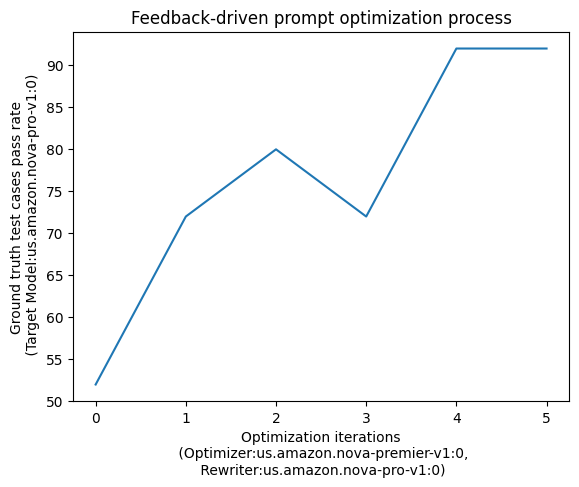

In [15]:
import matplotlib.pyplot as plt
import numpy as np

with open(iteration_file_path) as file:
    iter_data = json.load(file)
    # Define X and Y variable data
    x = np.array(range(0, len(iter_data)))
    y = np.array(list(map(lambda i: i['success_rate'], iter_data)))

    plt.plot(x, y)
    plt.xlabel(f"Optimization iterations\n (Optimizer:{prompt_optimizer_model_id},\n Rewriter:{prompt_rewriter_model_id})")  # add X-axis label
    plt.ylabel(f"Ground truth test cases pass rate\n (Target Model:{target_model_id})")  # add Y-axis label
    plt.title("Feedback-driven prompt optimization process")  # add title
    plt.show()